In [428]:
from pymatgen.core import Structure
from pymatgen.core.trajectory import Trajectory
from pymatgen.io.vasp.outputs import Xdatcar,Vasprun
# from pymatgen_diffusion.neb.pathfinder import IDPPSolver
# from pymatgen_diffusion.aimd.pathway import ProbabilityDensityAnalysis
# from pymatgen_diffusion.aimd.van_hove import VanHoveAnalysis
from pymatgen.analysis.transition_state import NEBAnalysis, combine_neb_plots
from matplotlib import pyplot as plt
from pymatgen.analysis.diffusion_analyzer import DiffusionAnalyzer,get_arrhenius_plot
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import optimize
import re
import seaborn as sns
import pandas as pd
import copy
import matplotlib.image as mpimg # mpimg 用于读取图片
from matplotlib.figure import Figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
import matplotlib as mpl
from matplotlib.pyplot import MultipleLocator

In [429]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

config = {
    "font.family":'serif',
    "font.size": 20,
    "mathtext.fontset":'stix',
    "font.serif": ['Times New Roman'],
    "font.weight":'bold'
}
rcParams.update(config)
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 30}
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [656]:
elements = 'S'
tet_index ={'Cl':1,'Br':1,'I':1,'S':2,'O':2}
oct_index ={'Cl':2,'Br':2,'I':2,'S':1,'O':1}
volume_dict = {'S':46.81,'Cl':30.81,'O':25.28,'Br':41.89,'I':54.687}
xmin = {'S':20,'O':10,'Cl':10}
xmax = {'S':80,'O':40,'Cl':70}
marker_1 = {'Oct':'o','Tet':'v'}
anion_charge = {'Cl':[0.25,0.85],'Br':[0.25,0.85],'I':[0.25,0.85],'S':[0.5,1.7],'O':[0,1.7]}
anion_charge_list = {'Cl':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'I':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]}
volume_list = [0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]
volume_per_list = [round(i*volume_dict[elements],2) for i in volume_list]
ss_c = [-i for i in anion_charge_list[elements]] 
ss_v = volume_list
step = 4
Ecut = 1.0
index1 = 0

In [657]:
results5 = pd.read_csv(f'./2022-07-11-fcc/fcc_Li{elements}_Ea.csv',header=None)
total_lens5 = results5.shape[0]/step
rlist5 = []
for i in range(0,int(total_lens5)):
    # print(i)
    t = results5.loc[i*step:i*step+step-1]
    t.columns = t.iloc[0]
    t = t.reset_index()
    t = t.drop(t.index[0])
    t['re_E'] = pd.to_numeric( t['re_E'])
    t['Energy'] = pd.to_numeric( t['Energy'])
    t['Force'] = pd.to_numeric( t['Force'])
#     print(t)
    rlist5.append(t)
data_list5 = []
for j in rlist5:
    data = {}
    title = j.columns[1].split('-')
    # print(j['re_E'].values[0])
    data['d'] = float(title[2])
    data['c'] = float(title[4])
    data['v'] = float(title[6])
    data['Etet-Eoct'] = float(j['re_E'].values[0])-float(j['re_E'].values[-1])
    data['Ea'] = j['re_E'].max()-j['re_E'].min()
    data['Etri'] = j['Energy'].values[1]
    data['Etet'] = j['Energy'].values[0]
    data['Eoct'] = j['Energy'].values[-1]
    data_list5.append(data)
r5 = pd.DataFrame(data_list5)

In [661]:
r5

,d,c,v,Etet-Eoct,Ea,Etri,Etet,Eoct
0,1.20,0.8,1.6,0.4200,0.4200,-116.2073,-116.0647,-116.4847
1,1.12,0.7,1.7,0.5660,0.5660,-106.5047,-106.1114,-106.6774
2,1.12,1.2,1.1,0.4094,0.4094,-122.0179,-121.9039,-122.3133
3,1.00,0.7,1.2,0.4303,0.4303,-94.7382,-94.4846,-94.9149
4,1.00,1.6,1.3,0.7228,0.7228,-167.2370,-166.7617,-167.4845
...,...,...,...,...,...,...,...,...
1009,1.04,1.4,1.6,0.7742,0.7742,-173.1104,-172.5246,-173.2988
1010,1.08,0.7,0.7,-0.3388,0.6827,-58.5521,-59.2348,-58.8960
1011,1.00,1.7,0.5,-0.8792,1.5873,115.2395,113.6522,114.5314
1012,1.00,1.4,0.8,0.1288,0.3840,-75.5180,-75.7732,-75.9020


In [662]:
ss1 = [1,1.12,1.16,1.2]
ss2 =[3.710959e-29
# ,1.807483e-01
# ,7.160662e-01
,1.585847e+00
,2.758709e+00
,4.194799e+00]
ss3 = [2.651429e-12
,   1.292910e-01
,   5.143897e-01
,   1.147123e+00
,   2.014352e+00
,   3.098644e+00]
ss2 = [round(i,2) for i in ss2]
ss3 = [round(i,2) for i in ss3]
ss4 = volume_list
ss4_1 = [round(k*volume_dict[elements],2) for k in volume_list]
marker_list = ['a','b','c','d','e','f','g'] 
ress_lists_Ea = []
v_list_3 = []
c_list_3 = []
d_list_3 = []
index_2 = 1
count_list = []
for index_1 in range(0,len(ss1)):
    ress_list1 = []
    v_list_2 = []
    c_list_2 = []
    d_list_2 = []
    count1 = 0
    for k in ss1[index_1:index_1+1]:
        
        
        for i in ss_c:
            data_l = []
            v_list_1 = []
            c_list_1 = []
            d_list_1 = []
            for j in ss_v:
        #         print(i)
                
#         r1[(r1['c']==-i)&(r1['v']==j)&(r1['d']==k)].values[0][5]+
                Ea_i = r5[(r5['c']==-i)&(r5['v']==j)&(r5['d']==k)].values[0][4]
    # -r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==k)].values[0][-1] - (r1[(r1['c']==-i)&(r1['v']==j)&(r1['d']==1)].values[0][5]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==1)].values[0][-1])
#                 E_tet_i = r2[(r2['c']==-i)&(r2['v']==j)&(r2['d']==k)].values[0][6]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==k)].values[0][-1] - (r2[(r2['c']==-i)&(r2['v']==j)&(r2['d']==1)].values[0][6]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==1)].values[0][-1])
                if float(Ea_i)<2:
                    count1 = count1 + 1
                data_l.append(Ea_i)
                v_list_1.append(round(j*volume_dict[elements],2))
                c_list_1.append(i)
                d_list_1.append(ss2[ss1.index(k)])
            ress_list1.append(data_l)
            v_list_2.append(v_list_1)
            c_list_2.append(c_list_1)
            d_list_2.append(d_list_1)
    ress_lists_Ea.append(ress_list1)
    v_list_3.append(v_list_2)
    c_list_3.append(c_list_2)
    d_list_3.append(d_list_2)
    count_list.append(count1/143)
# ress_list2 = []
# for k in ss1[0:1]:
#     for i in ss_c:
#         data_l = []
#         for j in ss_v:
#     #         print(i)
#             data_l.append(r2[(r2['c']==i)&(r2['v']==j)&(r2['d']==k)].values[0][3])
#         ress_list2.append(data_l)

# Ea_list = []
# for k in ss1[0:1]:
#     for i in ss_c:
#         data_l = []
#         for j in ss_v:
#             data_l.append(r1[(r1['c']==i)&(r1['v']==j)&(r1['d']==k)].values[0][4])
#         Ea_list.append(data_l)
# Etet_list = []
# for k in ss1[0:1]:
#     for i in ss_c:
#         data_l = []
#         for j in ss_v:
#             data_l.append(r1[(r1['c']==i)&(r1['v']==j)&(r1['d']==k)].values[0][5])
#         Etet_list.append(data_l)
# Eoct_list = []
# for k in ss1[0:1]:
#     for i in ss_c:
#         data_l = []
#         for j in ss_v:
#             data_l.append(r2[(r2['c']==i)&(r2['v']==j)&(r2['d']==k)].values[0][6])
#         Eoct_list.append(data_l)


In [663]:
ss1 = [1,1.12,1.16,1.2]
ss2 =[3.710959e-29
# ,1.807483e-01
# ,7.160662e-01
,1.585847e+00
,2.758709e+00
,4.194799e+00]
# ss3 = [2.651429e-12
# ,   1.292910e-01
# ,   5.143897e-01
# ,   1.147123e+00
# ,   2.014352e+00
# ,   3.098644e+00]
ss2 = [round(i,2) for i in ss2]
# ss3 = [round(i,2) for i in ss3]
ss4 = volume_list
ss4_1 = [round(k*volume_dict[elements],2) for k in volume_list]

# ss_c.reverse()
marker_list = ['a','b','c','d','e','f','g'] 
ress_lists = []
index_2 = 1
for index_1 in range(0,len(ss1)):
    ress_list1 = []
    for k in ss1[index_1:index_1+1]:
        print(k)
        for i in ss_c:
            data_l = []
            for j in ss_v:
                Ea_i = r5[(r5['c']==-i)&(r5['v']==j)&(r5['d']==k)].values[0][4]
                data_l.append(Ea_i)
            ress_list1.append(data_l)
    ress_lists.append(ress_list1)

df_Ea_list = []
# print(ress_lists[2])
for i in ress_lists:
    # print(i)
    df_Ea = pd.DataFrame(i,columns=ss4_1,index=ss_c)
    df_Ea1 = df_Ea[df_Ea<0.4]
#     df_tet_oct_norm = df_tet_oct.sub(df_tet_oct[ss1[0]], axis=0)
    df_Ea_list.append(df_Ea1)
    

1
1.12
1.16
1.2


In [664]:
ss1 = [1,1.12,1.16,1.2]
ss2 =[3.710959e-29
# ,1.807483e-01
# ,7.160662e-01
,1.585847e+00
,2.758709e+00
,4.194799e+00]
ss3 = [2.651429e-12
,   1.292910e-01
,   5.143897e-01
,   1.147123e+00
,   2.014352e+00
,   3.098644e+00]
ss2 = [round(i,2) for i in ss2]
ss3 = [round(i,2) for i in ss3]
ss4 = volume_list
ss4_1 = [round(k*volume_dict[elements],2) for k in volume_list]

# ss_c.reverse()
marker_list = ['a','b','c','d','e','f','g'] 
ress_lists = []
index_2 = 1
for index_1 in [0,1,2,3]:
    ress_list1 = []
    for k in ss1[index_1:index_1+1]:
        for i in ss_c:
            data_l = []
            for j in ss_v:
                Etet_Eoct_i = -r5[(r5['c']==-i)&(r5['v']==j)&(r5['d']==k)].values[0][3]
                data_l.append(Etet_Eoct_i)
            ress_list1.append(data_l)
    ress_lists.append(ress_list1)

df_Etet_Eoct_list = []
# print(ress_lists[2])
for i in ress_lists:
    # print(i)
    df_Ea = pd.DataFrame(i,columns=ss4_1,index=ss_c)
    # df_Ea1 = df_Ea[df_Ea]
#     df_tet_oct_norm = df_tet_oct.sub(df_tet_oct[ss1[0]], axis=0)
    df_Etet_Eoct_list.append(df_Ea)
    

In [665]:
# df_Etet_Eoct_list[]

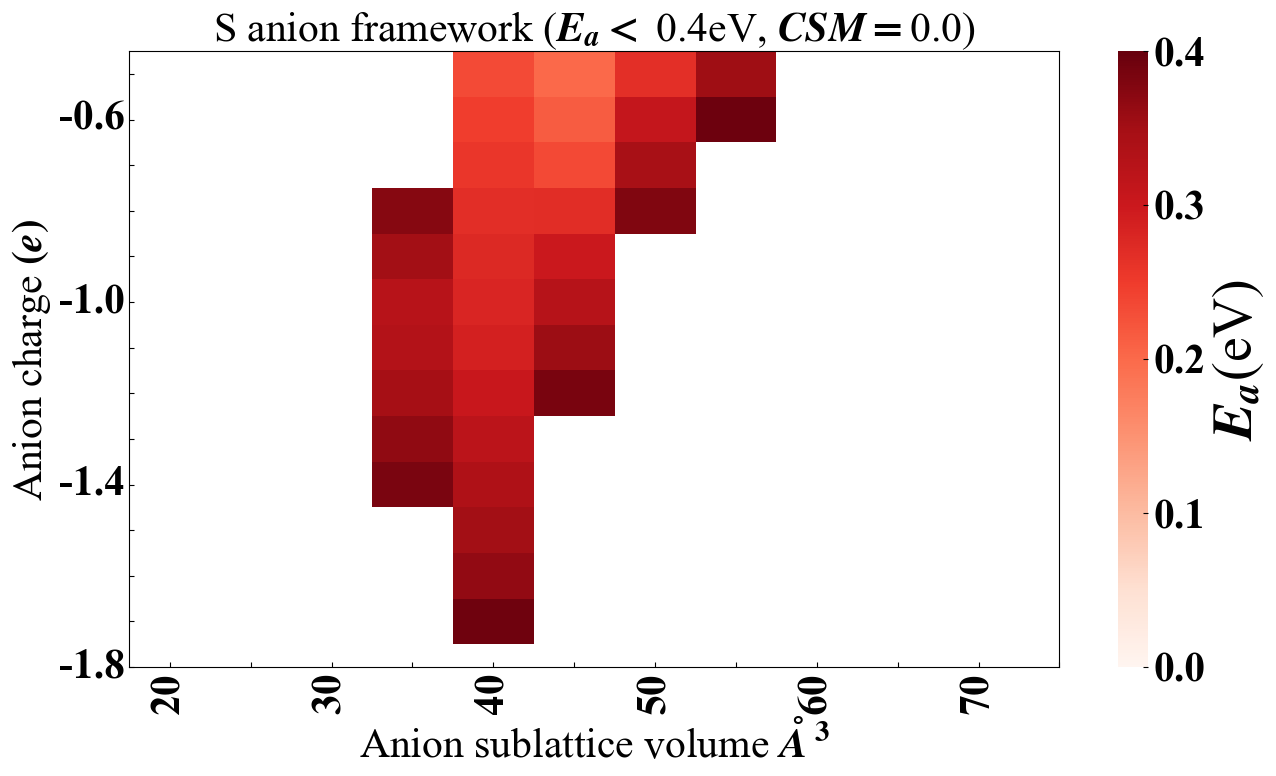

In [666]:
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
size1 = 30
size2 = 20
elements_compound_list = {'O':'O anion framework',"S":'S anion framework','Cl':'Cl-Framework','Br':'Br-Framework','I':'I-Framework'}
plt.figure(figsize=(15, 8))
# rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=9, l=5, sep=10)
# ax = sns.heatmap(df1,cmap='RdBu_r',center=0.00,cbar=True,vmin=-0.3,vmax=0.3,annot=True)\
# plt.text(-2,0,'(a)',fontsize=30)
# center=0.00
# annot=True

ax = sns.heatmap(df_Ea_list[index1],cmap='Reds',cbar=True,vmin=0,vmax=0.4,yticklabels=['',-0.6,'','','',-1.0,'','','',-1.4,'','','',-1.8,],xticklabels=[i for i in [20,'',30,'',40,'',50,'',60,'',70,'']])
plt.xlabel('Anion sublattice volume $\AA^3$',fontsize=size1, color='k') #x轴label的文本和字体大小
plt.ylabel(f'Anion charge $(e)$',fontsize=size1, color='k') #y轴label的文本和字体大小
plt.xticks(fontsize=30,rotation=90) #x轴刻度的字体大小（文本包含在pd_data中了）
plt.yticks(fontsize=30,rotation=0) #y轴刻度的字体大小（文本包含在pd_data中了）
plt.title(r'{elem} ($E_a<$ 0.4eV, $CSM=${csm})'.format(elem=elements_compound_list[elements],csm=ss2[index1]),fontsize=size1) #图片标题文本和字体大小
#设置colorbar的刻度字体大小
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=30)
#设置colorbar的label文本和字体大小
# ax.set_yticks(ticks = [0.6,1.0,1.4,1.8,])
ax.spines['top'].set_visible(True) #去掉上边框
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
cbar = ax.collections[0].colorbar
cbar.set_label(r'$E_a$(eV)',fontdict=font1)
# cbar = fig.add_axes([0.7,0.75,0.025,0.2])
plt.show()

In [667]:
import copy
ress_lists_Ea1 = copy.deepcopy(ress_lists_Ea)
for i in ress_lists_Ea1:
    for j in i:
        for k in j:
            # center
            if (k> Ecut)  :
                ress_lists_Ea1[ress_lists_Ea1.index(i)][i.index(j)][j.index(k)]=None

In [668]:
# ress_lists_Ea1

/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


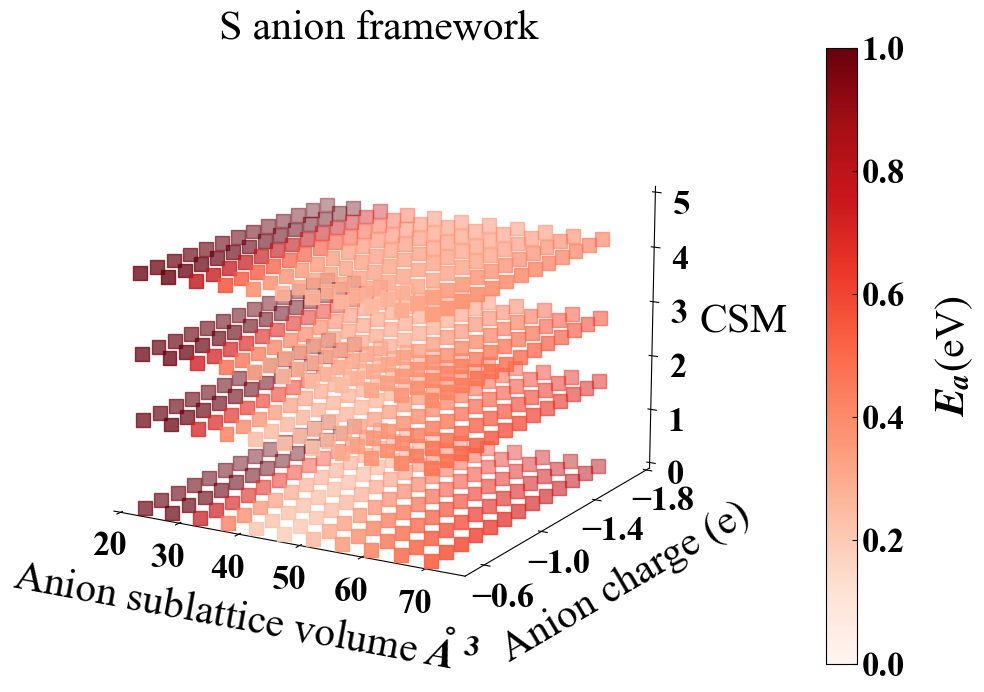

In [669]:
v_lim = {'Cl':[20,40],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[20,75],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[20,60],
          'I':[30,60],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[10,40]}

E_max = {'Cl':1.0,
#                  0.65,0.7,0.75,0.8,0.85],
           'S':2.0,
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':1.0,
          'I':1.0,
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':2.0}
anion_charge_list = {'Cl':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'I':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7]}
charge_coefficient_list1 = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
size1 = 30
size2 = 20
l_v = [round(k*volume_dict[elements],2) for k in volume_list]  
l_c = anion_charge_list[elements]
fig = plt.figure(figsize=(15,8))
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
# print(X)
# d = distortion_ratio_list
# ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
v = np.array(v_list_3)
c = np.array(c_list_3)
colors = np.array(ress_lists_Ea)
d = np.array(d_list_3)
# print(v)
# np.max(colors)
# cm = plt.cm.get_cmap('RdBu_r')
cm = plt.cm.get_cmap('Reds')
a = ax.scatter(v,c,d,c=colors,cmap=cm,s=100,marker='s',vmin=0,vmax=Ecut)
# for i in d[0:-2]:
#     cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)],levels=100, zdir='z', offset=i, cmap='RdBu_r')
# cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
# cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)
# cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)], zdir='y', offset=40, cmap=cm.coolwarm)
cbar = fig.colorbar(a,ax=ax,pad=0.12,fraction=0.036)
plt.title(f'{elements} anion framework',size=size1)
# - E_{i}^{oct}
cbar.set_label('$E_a$(eV)',rotation=90,labelpad=size2,size=size1)
cbar.ax.tick_params(labelsize=size1/1.2)
ax.view_init(elev=15,    # 仰角    # 方位角
            azim=-60)
# cbar.ax.set_label('Etet-Eoct')
ax.grid(False)
ax.tick_params(labelsize=size1/1.2)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.patch.set_alpha(0.0)
ax.set_xlabel(f'Anion sublattice volume $\AA^3$',labelpad=size2,size=size1)
ax.set_xlim(v_lim[elements][0], v_lim[elements][-1])
ax.set_ylabel('Anion charge (e)',labelpad=size2,size=size1)
ax.set_ylim(anion_charge_list[elements][0], anion_charge_list[elements][-1])
ax.set_zlabel('CSM', labelpad=size2,size=size1)
# ax.set_yticks(fontproperties = 'Times New Roman', size = 30)
ax.set_zticks(ticks = [0,1,2,3,4,5])
ax.set_yticks(ticks = [-0.6,-1.0,-1.4,-1.8,])
ax.set_xticks(ticks = [20,30,40,50,60,70])
ax.set_zlim(0,5)
plt.margins(0,0,0)
plt.savefig(f'./{elements}_Ea.png',bbox_inches='tight')
plt.show()

In [670]:
ss1 = [1,1.12,1.16,1.2]
ss2 =[3.710959e-29
# ,1.807483e-01
# ,7.160662e-01
,1.585847e+00
,2.758709e+00
,4.194799e+00]
ss3 = [2.651429e-12
,   1.292910e-01
,   5.143897e-01
,   1.147123e+00
,   2.014352e+00
,   3.098644e+00]
ss2 = [round(i,2) for i in ss2]
ss3 = [round(i,2) for i in ss3]
ss4 = volume_list
ss4_1 = [round(k*volume_dict[elements],2) for k in volume_list]
marker_list = ['a','b','c','d','e','f','g'] 
ress_lists_Ea2 = []
v_list_3 = []
c_list_3 = []
d_list_3 = []
index_2 = 1
count_list = []
for index_1 in range(0,len(ss1)):
    ress_list1 = []
    v_list_2 = []
    c_list_2 = []
    d_list_2 = []
    count1 = 0
    for k in ss1[index_1:index_1+1]:
        data_l = []
        v_list_1 = []
        c_list_1 = []
        d_list_1 = []
        for i in ss_c:

            for j in ss_v:
        #         print(i)
                
#         r1[(r1['c']==-i)&(r1['v']==j)&(r1['d']==k)].values[0][5]+
                Ea_i = r5[(r5['c']==-i)&(r5['v']==j)&(r5['d']==k)].values[0][4]
    # -r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==k)].values[0][-1] - (r1[(r1['c']==-i)&(r1['v']==j)&(r1['d']==1)].values[0][5]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==1)].values[0][-1])
#                 E_tet_i = r2[(r2['c']==-i)&(r2['v']==j)&(r2['d']==k)].values[0][6]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==k)].values[0][-1] - (r2[(r2['c']==-i)&(r2['v']==j)&(r2['d']==1)].values[0][6]-r_sf[(r_sf['c']==-i)&(r_sf['v']==j)&(r_sf['d']==1)].values[0][-1])
                # if float(Ea_i)<2:
                #     count1 = count1 + 1
                data_l.append(Ea_i)
                v_list_1.append(round(j*volume_dict[elements],2))
                c_list_1.append(i)
                # d_list_1.append(ss2[ss1.index(k)])
            # ress_list1.append(data_l)
            # v_list_2.append(v_list_1)
            # c_list_2.append(c_list_1)
            # d_list_2.append(d_list_1)
        ress_lists_Ea2.append(data_l)
        v_list_3.append(v_list_1)
        c_list_3.append(c_list_1)




In [671]:
# ress_lists_Ea2

In [672]:
import copy
ress_lists_Ea3 = copy.deepcopy(ress_lists_Ea2)
for i in ress_lists_Ea3:
    for j in i:
        if (j> 0.4)  :
            ress_lists_Ea3[ress_lists_Ea3.index(i)][i.index(j)]=None

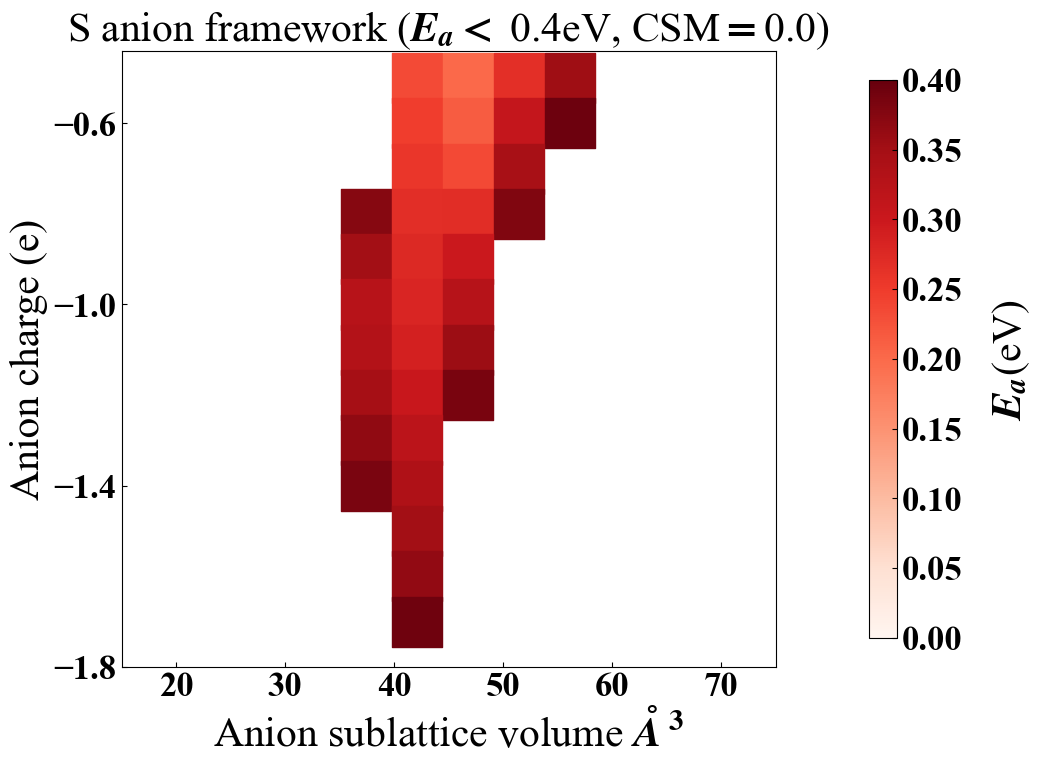

In [673]:
v_lim = {'Cl':[20,40],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[20,75],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[20,60],
          'I':[30,60],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[10,40]}

E_max = {'Cl':1.0,
#                  0.65,0.7,0.75,0.8,0.85],
           'S':2.0,
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':1.0,
          'I':1.0,
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':2.0}
anion_charge_list = {'Cl':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                  0.65,0.7,0.75,0.8,0.85],
           'S':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7],
#                 1.3,1.4,1.5,1.6,1.7],
           'Br':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'I':[0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85],
#                0.55,0.6,0.65,0.7,0.75,0.8,0.85],
          'O':[-0.5,-0.6,-0.7,-0.8,-0.9,-1,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7]}
charge_coefficient_list1 = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7]
elements_compound_list = {'O':'O anion framework',"S":'S anion framework','Cl':'Cl-Framework','Br':'Br-Framework','I':'I-Framework'}
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
size1 = 30
size2 = 20
l_v = [round(k*volume_dict[elements],2) for k in volume_list]  
l_c = anion_charge_list[elements]
# fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,8))

# ax = fig.gca(projection='2d')
# X, Y, Z = axes3d.get_test_data(0.05)
# print(X)
# d = distortion_ratio_list
# ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
v = np.array(v_list_3)
c = np.array(c_list_3)
colors = np.array(ress_lists_Ea3)
# d = np.array(d_list_3)
# print(v)
# np.max(colors)
# cm = plt.cm.get_cmap('RdBu_r')
cm = plt.cm.get_cmap('Reds')
a = ax.scatter(v[index1],c[index1],c=colors[index1],cmap=cm,s=1300,marker='s',vmin=0,vmax=0.4)
# for i in d[0:-2]:
#     cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)],levels=100, zdir='z', offset=i, cmap='RdBu_r')
# cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
# cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)
# cset = ax.contourf(v[d.index(i)], c[d.index(i)], colors[d.index(i)], zdir='y', offset=40, cmap=cm.coolwarm)
cbar = fig.colorbar(a,ax=ax,pad=0.12,fraction=0.036)
plt.title(r'{elem} ($E_a<$ 0.4eV, CSM$=${csm})'.format(elem=elements_compound_list[elements],csm=ss2[index1]),fontsize=size1)
# - E_{i}^{oct}
cbar.set_label('$E_a$(eV)',rotation=90,labelpad=size2,size=size1)
cbar.ax.tick_params(labelsize=size1/1.2)
# ax.view_init(elev=15,    # 仰角    # 方位角
#             azim=-60)
# cbar.ax.set_label('Etet-Eoct')
ax.grid(False)
ax.tick_params(labelsize=size1/1.2)
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.patch.set_alpha(0.0)
ax.set_xlabel(f'Anion sublattice volume $\AA^3$',size=size1)
ax.set_xlim(v_lim[elements][0]-5, v_lim[elements][-1])
ax.set_ylabel('Anion charge (e)',size=size1)
# ax.set_ylim(anion_charge_list[elements][-1], anion_charge_list[elements][0])
# ax.set_zlabel('CSM', labelpad=size2,size=size1)
ax.set_yticks(ticks = [-0.6,-1.0,-1.4,-1.8,],fontproperties = 'Times New Roman', size = 30)
ax.set_xticks(ticks = [20,30,40,50,60,70],fontproperties = 'Times New Roman', size = 30)
# ax.set_zticks(ticks = [0,1,2,3,4,5])
# ax.set_yticks()
# ax.set_xticks()
# ax.set_zlim(0,5)
# plt.margins(0,0,0)
# plt.savefig(f'./{elements}_Ea.png',bbox_inches='tight')
plt.show()

In [674]:
colors[0]

array([None, None, None, None, 0.2332, 0.2011, 0.2668, 0.3541, None, None,
       None, None, None, None, None, 0.2477, 0.21500000000000002, 0.3088,
       0.3938, None, None, None, None, None, None, None, 0.2568, 0.2357,
       0.3459, None, None, None, None, None, None, None, 0.3739, 0.2676,
       0.27, 0.3784, None, None, None, None, None, None, None, 0.3502,
       0.2751, 0.3001, None, None, None, None, None, None, None, None,
       0.3262, 0.2798, 0.3281, None, None, None, None, None, None, None,
       None, 0.3301, 0.28900000000000003, 0.3567, None, None, None, None,
       None, None, None, None, 0.3477, 0.30379999999999996, 0.385, None,
       None, None, None, None, None, None, None, 0.3669, 0.3204, None,
       None, None, None, None, None, None, None, None, 0.384, 0.3366,
       None, None, None, None, None, None, None, None, None, None,
       0.35150000000000003, None, None, None, None, None, None, None,
       None, None, None, 0.3653, None, None, None, None, None, No

In [675]:
Ea_csm ={'0.4':[0.23776223776223776,
 0.2517482517482518,
 0.26573426573426573,
 0.3006993006993007,
 0.35664335664335667,
 0.4405594405594406],'0.3':[0.08391608391608392,
 0.09090909090909091,
 0.08391608391608392,
 0.09090909090909091,
 0.06993006993006994,
 0.06993006993006994],'0.2':[0.08391608391608392,
 0.09090909090909091,
 0.08391608391608392,
 0.09090909090909091,
 0.06993006993006994,
 0.06993006993006994],'0.5':[0.38461538461538464,
 0.3916083916083916,
 0.42657342657342656,
 0.4825174825174825,
 0.6083916083916084,
 0.6363636363636364],'0.6':[0.5524475524475524,
 0.5524475524475524,
 0.6153846153846154,
 0.6643356643356644,
 0.7342657342657343,
 0.7272727272727273],'0.7':[0.7062937062937062,
 0.7132867132867133,
 0.7622377622377622,
 0.8111888111888111,
 0.7902097902097902,
 0.7272727272727273],'0.8':[0.8111888111888111,
 0.8181818181818182,
 0.8181818181818182,
 0.8181818181818182,
 0.8181818181818182,
 0.8181818181818182],'1.2':[1.0, 1.0, 1.0, 1.0, 1.0, 1.0],'0':[0, 0, 0, 0, 0, 0]}

[' CSM = 0.0', ' CSM = 1.59', ' CSM = 2.76', ' CSM = 4.19']


/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-v" (-> linestyle='-'). The keyword argument will take precedence.
/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-^" (-> linestyle='-'). The keyword argument will take precedence.
/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-<" (-> linestyle='-'). The keyword

(0.0, 1.2, 0.0, 1.0)

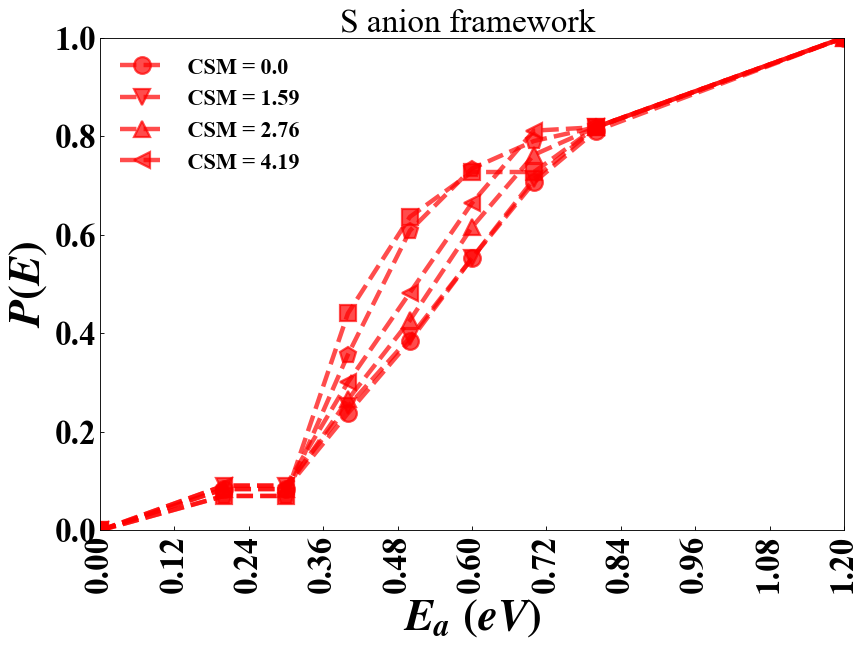

In [676]:
# xstick = volume_per_list
xt = anion_charge_list[elements]

type_1 = ''
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
plt.figure(figsize=(12,8),dpi=80)
# plt.xlim((-0.1,3))
# plt.ylim((-0.1,0.5))

a_plt = []
ymax = 0.5
ymin = -0.5
# marker_list =  ['-o', '-v', '-^', '-<','-p']
marker_list1 =  ['-o', '-v', '-^','-<','-p','-s',"->","-P","-*","-H","-+"]
num_plots = len(xt)+2
colormap = plt.cm.RdBu_r
# cmap = mpl.cm.cool
color_array = [colormap(i) for i in np.linspace(0, 1, num_plots)]
# cmap = mpl.cm.cool
# norm = mpl.colors.Normalize(vmin=5, vmax=10)
min, max = (-40, 30)
step = 20
mymap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['red','blue'])
x = [0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.2]
# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(min,max+step,step)
# norm = mpl.colors.Normalize(vmin=xstick[0], vmax=xstick[-1])   
# norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
# cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu_r)
# cmap.set_array([])
# plt.clf()

csm_list = [0,1,2,3,4,5]
Ea_csm_list = []
xstick = csm_list
for j in csm_list:
    list1 = []
    for i in x:
        list1.append(Ea_csm[str(i)][j])
    Ea_csm_list.append(list1)
a_plt = []
for k in xstick:

#     print(ss.index(k))
    # print(df_tet_oct1)
#     t_plt, = plt.plot(df_tet_oct_list[0].columns.tolist(),df_tet_oct_list[0].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[0]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
    t_plt1, = plt.plot(x,Ea_csm_list[k],f'{marker_list1[k]}',c='r', markersize=15, linewidth=4,markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt2, = plt.plot(df_tet_oct_list[2].columns.tolist(),df_tet_oct_list[2].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[2]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt3, = plt.plot(df_tet_oct_list[3].columns.tolist(),df_tet_oct_list[3].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[3]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt4, = plt.plot(df_tet_oct_list[4].columns.tolist(),df_tet_oct_list[4].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[4]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
    # t_plt5, = plt.plot(df_Etet_Eoct_list[5].columns.tolist(),df_Etet_Eoct_list[5].iloc[int(xt.index(k))].tolist(),f'{marker_list1[5]}',
    #              c=color_array[xt.index(k)], markersize=15, linewidth=4,
    #               markeredgewidth=2,alpha=0.7,linestyle="--",)
                  # markerfacecolor='none')
  # t_plt1,=plt.plot(df_oct_norm.columns.tolist(),df_oct_norm.iloc[int(xstick.index(k))].tolist(),'-o',c=color_array[xstick.index(k)], markersize=15, linewidth=4,
  #               markeredgewidth=2,alpha=0.7,linestyle="--", )
  #                  markerfacecolor='none')
  # t_plt,=plt.plot(df_delta.columns.tolist(),df_delta.iloc[int(xstick.index(k))].tolist(),'-*',
  #              c=color_array[xstick.index(k)], markersize=15, linewidth=4,
  #               markeredgewidth=2,alpha=0.7,linestyle="--",)
  #                 markerfacecolor='none')
# t_plt2,t_plt3,t_plt4
    a_plt.append(t_plt1)
#     a_plt.append(t_plt1)
#     print(a_plt)
# print(marker_list)
# markersize=15, linewidth=4,
#                  markeredgewidth=2
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# print(a_plt)

# cbar.set_label(f'CSM',size=30)

# cbar.set_label(f'Volume per {elements} Atom($\AA^3$)',size=30)
plt.tick_params(labelsize=30)
plt.xlim(0)
# plt.ylim(-0.05,0.6)
plt.xlabel(f'$E_a$ $(eV)$',fontdict=font1)
plt.ylabel(r'$P(E)$',fontdict=font1)
# plt.ylabel(r'$E_{i}$ (eV)',font1)
# plt.ylabel(r'$E_i^{tet}-E_i^{oct} (eV)$',font1)
new_ticks = np.linspace(0,1.2, 11)
plt.xticks(new_ticks)
form_str='form'
# plt.text(xmin[f'{elements}']-10,ymax,f'({marker_list[index_1]})',fontsize=30)
plt.title(f'{elements} anion framework ',fontsize=30) #图片标题文本和字体大小
plt.yticks(fontproperties = 'Times New Roman', fontsize=30)
plt.xticks(fontproperties = 'Times New Roman', fontsize=30,rotation=90)
print([f'{type_1} CSM = '+str(round(i,2)) for i in ss2])
l1 = plt.legend(a_plt,[f'{type_1} CSM = '+str(round(i,2)) for i in ss2],loc='best',prop = {'size':20},frameon=False)
# l1 = plt.legend(a_plt,['Tet-Oct'],loc='upper left',prop = {'size':20},frameon=False)
plt.axis([0,1.2,0,1])

/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-v" (-> linestyle='-'). The keyword argument will take precedence.
/Users/runix/miniconda3/envs/Dproj/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.


[' CSM = 0.0', ' CSM = 1.59', ' CSM = 2.76', ' CSM = 4.19']


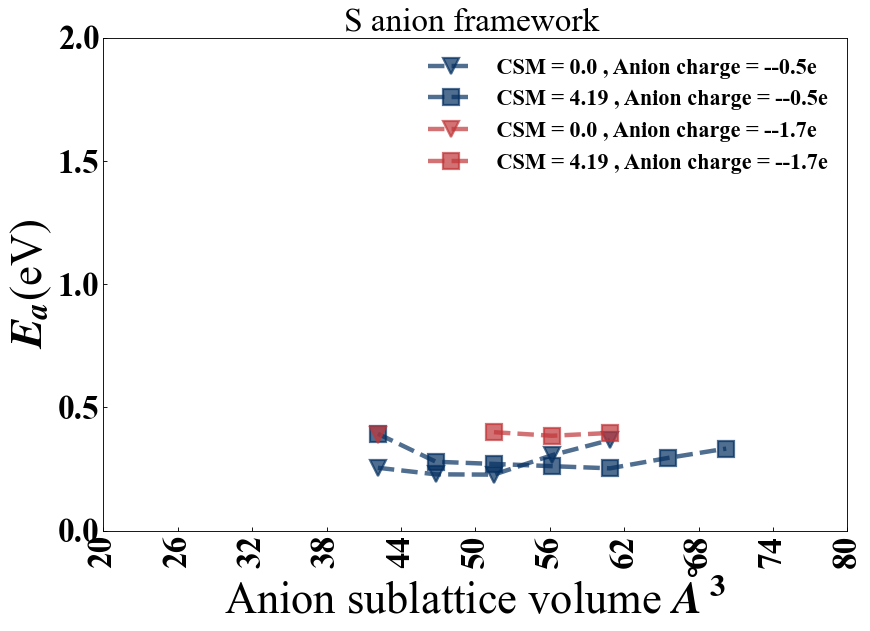

In [677]:
# xstick = volume_per_list
xt = anion_charge_list[elements]
xstick = [-0.5,-1.7]
type_1 = ''
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
plt.figure(figsize=(12,8),dpi=80)
# plt.xlim((-0.1,3))
# plt.ylim((-0.1,0.5))

a_plt = []
ymax = 0.5
ymin = -0.5
# marker_list =  ['-o', '-v', '-^', '-<','-p']
marker_list1 =  ['-o', '-v', '-^','-<','-p','-s',"->","-P","-*","-H","-+"]
num_plots = len(xt)+2
colormap = plt.cm.RdBu_r
# cmap = mpl.cm.cool
color_array = [colormap(i) for i in np.linspace(0, 1, num_plots)]
# cmap = mpl.cm.cool
# norm = mpl.colors.Normalize(vmin=5, vmax=10)
min, max = (-40, 30)
step = 20
mymap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['red','blue'])
# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(min,max+step,step)
norm = mpl.colors.Normalize(vmin=xstick[0], vmax=xstick[-1])
# norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu_r)
# cmap.set_array([])
# plt.clf()

vol_list = [0,1,2,3]
a_plt = []
for k in xstick:
#     print(ss.index(k))
    # print(df_tet_oct1)
#     t_plt, = plt.plot(df_tet_oct_list[0].columns.tolist(),df_tet_oct_list[0].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[0]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
    t_plt1, = plt.plot(df_Ea_list[1].columns.tolist(),df_Ea_list[1].iloc[int(xt.index(k))].tolist(),f'{marker_list1[1]}',
                 c=color_array[xt.index(k)], markersize=15, linewidth=4,
                  markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt2, = plt.plot(df_tet_oct_list[2].columns.tolist(),df_tet_oct_list[2].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[2]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt3, = plt.plot(df_tet_oct_list[3].columns.tolist(),df_tet_oct_list[3].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[3]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt4, = plt.plot(df_tet_oct_list[4].columns.tolist(),df_tet_oct_list[4].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[4]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
    t_plt5, = plt.plot(df_Ea_list[-1].columns.tolist(),df_Ea_list[-1].iloc[int(xt.index(k))].tolist(),f'{marker_list1[5]}',
                 c=color_array[xt.index(k)], markersize=15, linewidth=4,
                  markeredgewidth=2,alpha=0.7,linestyle="--",)
    a_plt.append(t_plt1)
    a_plt.append(t_plt5)
                  # markerfacecolor='none')
  # t_plt1,=plt.plot(df_oct_norm.columns.tolist(),df_oct_norm.iloc[int(xstick.index(k))].tolist(),'-o',c=color_array[xstick.index(k)], markersize=15, linewidth=4,
  #               markeredgewidth=2,alpha=0.7,linestyle="--", )
  #                  markerfacecolor='none')
  # t_plt,=plt.plot(df_delta.columns.tolist(),df_delta.iloc[int(xstick.index(k))].tolist(),'-*',
  #              c=color_array[xstick.index(k)], markersize=15, linewidth=4,
  #               markeredgewidth=2,alpha=0.7,linestyle="--",)
  #                 markerfacecolor='none')
# t_plt2,t_plt3,t_plt4
# a_plt = [t_plt1,t_plt5]
#     a_plt.append(t_plt1)
#     print(a_plt)
# print(marker_list)
# markersize=15, linewidth=4,
#                  markeredgewidth=2
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# print(a_plt)
# cbar = plt.colorbar(cmap)
# cbar.ax.set_yticklabels([-0.4,-0.6,-0.8,-1.0,-1.2,-1.4,-1.6,-1.8,-2.0])
# # cbar.set_label(f'CSM',size=30)
# cbar.set_label(f'Anion Charge (e)',size=30)
# cbar.set_label(f'Volume per {elements} Atom($\AA^3$)',size=30)
plt.tick_params(labelsize=30)
plt.xlim(0)
# plt.ylim(-0.05,0.6)
plt.xlabel(f'Anion sublattice volume $\AA^3$',fontdict=font1)
plt.ylabel(r'$E_{a}$(eV)',fontdict=font1)
# plt.ylabel(r'$E_{i}$ (eV)',font1)
# plt.ylabel(r'$E_i^{tet}-E_i^{oct} (eV)$',font1)
new_ticks = np.linspace(xmin[f'{elements}'], xmax[f'{elements}'], 11)
plt.xticks(new_ticks)
form_str='form'
# plt.text(xmin[f'{elements}']-10,ymax,f'({marker_list[index_1]})',fontsize=30)
plt.title(f'{elements} anion framework ',fontsize=30) #图片标题文本和字体大小
plt.yticks(fontproperties = 'Times New Roman', fontsize=30)
plt.xticks(fontproperties = 'Times New Roman', fontsize=30,rotation=90)
print([f' CSM = '+str(round(i,2)) for i in ss2])
l1 = plt.legend(a_plt,[f' CSM = '+str(round(i,2))+' , Anion charge = -'+str(round(j,2))+'e' for i,j in [(ss2[0],xt[0]),(ss2[-1],xt[0]),(ss2[0],xt[-1]),(ss2[-1],xt[-1])]],loc='best',prop = {'size':20},frameon=False)
# l1 = plt.legend(a_plt,['Tet-Oct'],loc='upper left',prop = {'size':20},frameon=False)
plt.axis([xmin[f'{elements}'],xmax[f'{elements}'],0,2.0])
plt.savefig(f'./{elements}_E_a.png',bbox_inches='tight')

In [678]:
# xstick = volume_per_list
xt = anion_charge_list[elements]
xstick = [0.5,1.7]
type_1 = ''
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
plt.figure(figsize=(12,8),dpi=80)
# plt.xlim((-0.1,3))
# plt.ylim((-0.1,0.5))

a_plt = []
ymax = 0.5
ymin = -0.5
# marker_list =  ['-o', '-v', '-^', '-<','-p']
marker_list1 =  ['-o', '-v', '-^','-<','-p','-s',"->","-P","-*","-H","-+"]
num_plots = len(xt)+2
colormap = plt.cm.RdBu_r
# cmap = mpl.cm.cool
color_array = [colormap(i) for i in np.linspace(0, 1, num_plots)]
# cmap = mpl.cm.cool
# norm = mpl.colors.Normalize(vmin=5, vmax=10)
min, max = (-40, 30)
step = 20
mymap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['red','blue'])
# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(min,max+step,step)
norm = mpl.colors.Normalize(vmin=xstick[0], vmax=xstick[-1])
# norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu_r)
# cmap.set_array([])
# plt.clf()

vol_list = [0,1,2,3]
a_plt = []
for k in xstick:
#     print(ss.index(k))
    # print(df_tet_oct1)
#     t_plt, = plt.plot(df_tet_oct_list[0].columns.tolist(),df_tet_oct_list[0].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[0]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
    t_plt1, = plt.plot(df_Etet_Eoct_list[1].columns.tolist(),df_Etet_Eoct_list[1].iloc[int(xt.index(k))].tolist(),f'{marker_list1[1]}',
                 c=color_array[xt.index(k)], markersize=15, linewidth=4,
                  markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt2, = plt.plot(df_tet_oct_list[2].columns.tolist(),df_tet_oct_list[2].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[2]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt3, = plt.plot(df_tet_oct_list[3].columns.tolist(),df_tet_oct_list[3].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[3]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt4, = plt.plot(df_tet_oct_list[4].columns.tolist(),df_tet_oct_list[4].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[4]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
    t_plt5, = plt.plot(df_Etet_Eoct_list[-1].columns.tolist(),df_Etet_Eoct_list[-1].iloc[int(xt.index(k))].tolist(),f'{marker_list1[5]}',
                 c=color_array[xt.index(k)], markersize=15, linewidth=4,
                  markeredgewidth=2,alpha=0.7,linestyle="--",)
    a_plt.append(t_plt1)
    a_plt.append(t_plt5)
                  # markerfacecolor='none')
  # t_plt1,=plt.plot(df_oct_norm.columns.tolist(),df_oct_norm.iloc[int(xstick.index(k))].tolist(),'-o',c=color_array[xstick.index(k)], markersize=15, linewidth=4,
  #               markeredgewidth=2,alpha=0.7,linestyle="--", )
  #                  markerfacecolor='none')
  # t_plt,=plt.plot(df_delta.columns.tolist(),df_delta.iloc[int(xstick.index(k))].tolist(),'-*',
  #              c=color_array[xstick.index(k)], markersize=15, linewidth=4,
  #               markeredgewidth=2,alpha=0.7,linestyle="--",)
  #                 markerfacecolor='none')
# t_plt2,t_plt3,t_plt4
# a_plt = [t_plt1,t_plt5]
#     a_plt.append(t_plt1)
#     print(a_plt)
# print(marker_list)
# markersize=15, linewidth=4,
#                  markeredgewidth=2
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# print(a_plt)
# cbar = plt.colorbar(cmap)
# cbar.ax.set_yticklabels([-0.4,-0.6,-0.8,-1.0,-1.2,-1.4,-1.6,-1.8,-2.0])
# # cbar.set_label(f'CSM',size=30)
# cbar.set_label(f'Anion Charge (e)',size=30)
# cbar.set_label(f'Volume per {elements} Atom($\AA^3$)',size=30)
plt.tick_params(labelsize=30)
plt.xlim(0)
# plt.ylim(-0.05,0.6)
plt.xlabel(f'Anion sublattice volume $\AA^3$',fontdict=font1)
plt.ylabel(r'$E_{tet}$-$E_{oct}$(eV)',fontdict=font1)
# plt.ylabel(r'$E_{i}$ (eV)',font1)
# plt.ylabel(r'$E_i^{tet}-E_i^{oct} (eV)$',font1)
new_ticks = np.linspace(xmin[f'{elements}'], xmax[f'{elements}'], 11)
plt.xticks(new_ticks)
form_str='form'
# plt.text(xmin[f'{elements}']-10,ymax,f'({marker_list[index_1]})',fontsize=30)
plt.title(f'{elements} anion framework ',fontsize=30) #图片标题文本和字体大小
plt.yticks(fontproperties = 'Times New Roman', fontsize=30)
plt.xticks(fontproperties = 'Times New Roman', fontsize=30,rotation=90)
print([f' CSM = '+str(round(i,2)) for i in ss2])
l1 = plt.legend(a_plt,[f' CSM = '+str(round(i,2))+' , Anion charge = -'+str(round(j,2))+'e' for i,j in [(ss2[0],xt[0]),(ss2[-1],xt[0]),(ss2[0],xt[-1]),(ss2[-1],xt[-1])]],loc='best',prop = {'size':20},frameon=False)
# l1 = plt.legend(a_plt,['Tet-Oct'],loc='upper left',prop = {'size':20},frameon=False)
plt.axis([xmin[f'{elements}'],xmax[f'{elements}'],-1.5,1.5])
plt.savefig(f'./{elements}_E_tet_oct.png',bbox_inches='tight')

ValueError: 0.5 is not in list

<Figure size 960x640 with 0 Axes>

In [ ]:
# xstick = volume_per_list
xt = anion_charge_list[elements]
xstick = [-0.5,-1.7]
type_1 = ''
font1 = {'family' : 'Times New Roman',
# 'weight' : 'normal',
'size'   : 40}
plt.figure(figsize=(12,8),dpi=80)
# plt.xlim((-0.1,3))
# plt.ylim((-0.1,0.5))

a_plt = []
ymax = 0.5
ymin = -0.5
# marker_list =  ['-o', '-v', '-^', '-<','-p']
marker_list1 =  ['-o', '-v', '-^','-<','-p','-s',"->","-P","-*","-H","-+"]
num_plots = len(xt)+2
colormap = plt.cm.RdBu_r
# cmap = mpl.cm.cool
color_array = [colormap(i) for i in np.linspace(0, 1, num_plots)]
# cmap = mpl.cm.cool
# norm = mpl.colors.Normalize(vmin=5, vmax=10)
min, max = (-40, 30)
step = 20
mymap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['red','blue'])
# Using contourf to provide my colorbar info, then clearing the figure
Z = [[0,0],[0,0]]
levels = range(min,max+step,step)
norm = mpl.colors.Normalize(vmin=xstick[0], vmax=xstick[-1])
# norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu_r)
# cmap.set_array([])
# plt.clf()

vol_list = [0,1,2,3]

for k in xstick:
#     print(ss.index(k))
    # print(df_tet_oct1)
#     t_plt, = plt.plot(df_tet_oct_list[0].columns.tolist(),df_tet_oct_list[0].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[0]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
    t_plt1, = plt.plot(df_Etet_Eoct_list[0].columns.tolist(),df_Etet_Eoct_list[0].iloc[int(xt.index(k))].tolist(),f'{marker_list1[1]}',
                 c=color_array[xt.index(k)], markersize=15, linewidth=4,
                  markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt2, = plt.plot(df_tet_oct_list[2].columns.tolist(),df_tet_oct_list[2].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[2]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt3, = plt.plot(df_tet_oct_list[3].columns.tolist(),df_tet_oct_list[3].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[3]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
#     t_plt4, = plt.plot(df_tet_oct_list[4].columns.tolist(),df_tet_oct_list[4].iloc[int(xstick.index(k))].tolist(),f'{marker_list1[4]}',
#                  c=color_array[xstick.index(k)], markersize=15, linewidth=4,
#                   markeredgewidth=2,alpha=0.7,linestyle="--",)
    t_plt5, = plt.plot(df_Etet_Eoct_list[-1].columns.tolist(),df_Etet_Eoct_list[-1].iloc[int(xt.index(k))].tolist(),f'{marker_list1[5]}',
                 c=color_array[xt.index(k)], markersize=15, linewidth=4,
                  markeredgewidth=2,alpha=0.7,linestyle="--",)
                  # markerfacecolor='none')
  # t_plt1,=plt.plot(df_oct_norm.columns.tolist(),df_oct_norm.iloc[int(xstick.index(k))].tolist(),'-o',c=color_array[xstick.index(k)], markersize=15, linewidth=4,
  #               markeredgewidth=2,alpha=0.7,linestyle="--", )
  #                  markerfacecolor='none')
  # t_plt,=plt.plot(df_delta.columns.tolist(),df_delta.iloc[int(xstick.index(k))].tolist(),'-*',
  #              c=color_array[xstick.index(k)], markersize=15, linewidth=4,
  #               markeredgewidth=2,alpha=0.7,linestyle="--",)
  #                 markerfacecolor='none')
# t_plt2,t_plt3,t_plt4
a_plt = [t_plt1,t_plt5]
#     a_plt.append(t_plt1)
#     print(a_plt)
# print(marker_list)
# markersize=15, linewidth=4,
#                  markeredgewidth=2
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# print(a_plt)
# cbar = plt.colorbar(cmap)
# cbar.ax.set_yticklabels([-0.4,-0.6,-0.8,-1.0,-1.2,-1.4,-1.6,-1.8,-2.0])
# # cbar.set_label(f'CSM',size=30)
# cbar.set_label(f'Anion Charge (e)',size=30)
# cbar.set_label(f'Volume per {elements} Atom($\AA^3$)',size=30)
plt.tick_params(labelsize=30)
plt.xlim(0)
# plt.ylim(-0.05,0.6)
plt.xlabel(f'Anion Lattice Volume $\AA^3$',fontdict=font1)
plt.ylabel(r'$E_{tet}$-$E_{oct}$(eV)',fontdict=font1)
# plt.ylabel(r'$E_{i}$ (eV)',font1)
# plt.ylabel(r'$E_i^{tet}-E_i^{oct} (eV)$',font1)
new_ticks = np.linspace(xmin[f'{elements}'], xmax[f'{elements}'], 11)
plt.xticks(new_ticks)
form_str='form'
# plt.text(xmin[f'{elements}']-10,ymax,f'({marker_list[index_1]})',fontsize=30)
plt.title(f'{elements} anion framework ',fontsize=30) #图片标题文本和字体大小
plt.yticks(fontproperties = 'Times New Roman', fontsize=30)
plt.xticks(fontproperties = 'Times New Roman', fontsize=30,rotation=90)
           
           
           
# print([f'{type_1} CSM = '+str(round(i,2)) for i in ss2])
l1 = plt.legend(a_plt,[f' CSM = '+str(round(i,2))+' , Anion Charge = '+str(round(j,2))+'e' for i,j in [(ss2[0],xt[0]),(ss2[-1],xt[0]),(ss2[0],xt[-1]),(ss2[-1],xt[-1])]],loc='best',prop = {'size':20},frameon=False)
# l1 = plt.legend(a_plt,['Tet-Oct'],loc='upper left',prop = {'size':20},frameon=False)
plt.axis([xmin[f'{elements}'],xmax[f'{elements}'],-1.5,1.5])